In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
import numpy as np
import pandas as pd
import sklearn
import sklearn.model_selection
import os

from sklearn import preprocessing as pp

from yahoo_fin import stock_info as si
import talib as tlb

In [2]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4246672237928390269
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1445583259
locality {
  bus_id: 1
  links {
  }
}
incarnation: 621231807006561528
physical_device_desc: "device: 0, name: NVIDIA GeForce 840M, pci bus id: 0000:04:00.0, compute capability: 5.0"
]


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
"""Faire tourner sur gpu"""

'Faire tourner sur gpu'

In [5]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce 840M, pci bus id: 0000:04:00.0, compute capability: 5.0



In [6]:
"""pb rencontrés : 
could not convert string to float: 'BTC-USD' lors de la cellule x_train, y_train

"""
"""on ne savait pas utiliser le scaler, il a fallu sauvegarder dans un dictionnaire"""

'on ne savait pas utiliser le scaler, il a fallu sauvegarder dans un dictionnaire'

In [7]:
"""reste a modifier les noms de variables pour pas crammer le copier collé"""

'reste a modifier les noms de variables pour pas crammer le copier collé'

In [8]:
"""bien plus simple de faire par cellule avec Jupyter que par fonction, on voit où ca ne marche pas"""

'bien plus simple de faire par cellule avec Jupyter que par fonction, on voit où ca ne marche pas'

In [9]:
possible_features = ['open', 'high', 'low', 'close', 'volume', 'close 7 days mean', 'close 14 days mean', 'close 20 days mean', 'close 50 days mean', 'ema', 'upperband', 'middleband', 'lowerband', 'rsi', 'macd', 'bop', 'obv', 'natr', 'sine', 'leadsine', 'CDLKICKINGBYLENGTH', 'CDLTAKURI', 'CDLHARAMI', 'CDLDOJI', 'CDLDRAGONFLYDOJI', 'CDLLONGLEGGEDDOJI']

In [10]:
"""Paramètres"""
ticker = 'BTC-USD' #choix de l'action à étudier

n = 60 #nombre de jours considérés par le modèle précédant la date voulue
days_predicted = 10 #on prévoit le prix de l'action à la date t + days_predicted
test_size = 0.2 #part des données réservée au test du modèle
#features = ['open', 'high', 'low', 'close', 'volume']
shuffle = True
features = possible_features #liste d'indicateurs financiers utiles à la prédiction




In [11]:
"""On charge la dataset"""

df = si.get_data(ticker) 
df.tail()

,open,high,low,close,adjclose,volume,ticker
2021-05-19,36753.667969,42462.984375,35050.617188,40782.738281,40782.738281,8.828194e+10,BTC-USD
2021-05-20,40596.949219,42172.171875,33616.453125,37304.691406,37304.691406,8.205162e+10,BTC-USD
2021-05-21,37371.031250,38831.054688,35383.683594,37536.632812,37536.632812,5.737727e+10,BTC-USD
2021-05-22,37531.449219,38289.218750,31227.339844,34770.582031,34770.582031,7.846927e+10,BTC-USD
2021-05-24,35284.609375,38612.437500,34564.988281,37985.816406,37985.816406,6.598306e+10,BTC-USD


In [12]:
df.drop(columns=['ticker', 'adjclose'], inplace = True)
df = df.astype(np.float64)
df.head()

,open,high,low,close,volume
2014-09-16,465.864014,468.174011,452.421997,457.334015,21056800.0
2014-09-17,456.859985,456.859985,413.104004,424.440002,34483200.0
2014-09-18,424.102997,427.834991,384.532013,394.795990,37919700.0
2014-09-19,394.673004,423.295990,389.882996,408.903992,36863600.0
2014-09-20,408.084991,412.425995,393.181000,398.821014,26580100.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2442 entries, 2014-09-16 to 2021-05-24
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2438 non-null   float64
 1   high    2438 non-null   float64
 2   low     2438 non-null   float64
 3   close   2438 non-null   float64
 4   volume  2438 non-null   float64
dtypes: float64(5)
memory usage: 114.5 KB


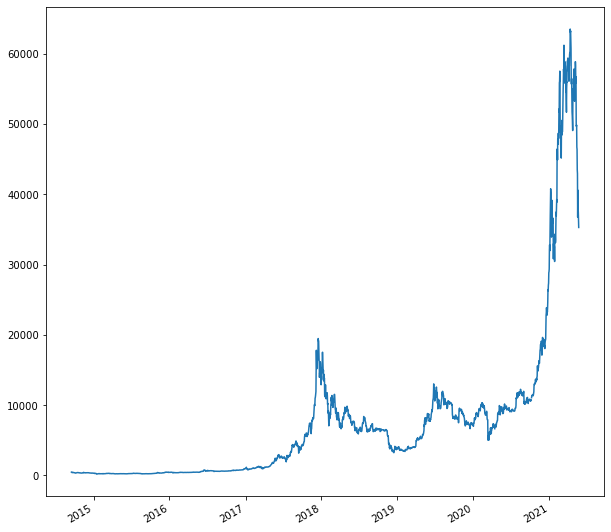

In [14]:
"""print les colonnes"""

df['open'].plot(figsize = (10, 10))

In [15]:
df.shape

(2442, 5)

In [16]:
df.iloc[2500:,:]

,open,high,low,close,volume


In [17]:
#df = df.iloc[2500:,:] #on prend df a partir des années 90 pour KO, 96 pour MSFT

In [18]:
df #on prend df a partir des années 90 pour KO, 96 pour MSFT

,open,high,low,close,volume
2014-09-16,465.864014,468.174011,452.421997,457.334015,2.105680e+07
2014-09-17,456.859985,456.859985,413.104004,424.440002,3.448320e+07
2014-09-18,424.102997,427.834991,384.532013,394.795990,3.791970e+07
2014-09-19,394.673004,423.295990,389.882996,408.903992,3.686360e+07
2014-09-20,408.084991,412.425995,393.181000,398.821014,2.658010e+07
...,...,...,...,...,...
2021-05-19,36753.667969,42462.984375,35050.617188,40782.738281,8.828194e+10
2021-05-20,40596.949219,42172.171875,33616.453125,37304.691406,8.205162e+10
2021-05-21,37371.031250,38831.054688,35383.683594,37536.632812,5.737727e+10
2021-05-22,37531.449219,38289.218750,31227.339844,34770.582031,7.846927e+10


In [19]:
df.dropna(inplace = True) #drop les NaN pour pouvoir calculer les indicateurs

In [20]:
df.shape

(2438, 5)

In [21]:
"""Fonctions des indicateurs 
(yahoo_fin permet uniquement d'obtenir les 5 colonnes 'adjclose', 'volume', 'open', 'high', 'low')
"""
########Overlap Studies Functions


#Moyennes mobiles :
#7j
df['close 7 days mean'] = df['close'].rolling(window = 7).mean()
#14j
df['close 14 days mean'] = df['close'].rolling(window = 14).mean()
#20j
df['close 20 days mean'] = df['close'].rolling(window = 20).mean()
#50j
df['close 50 days mean'] = df['close'].rolling(window = 50).mean()


#On utilise le package talib pour avoir les indicateurs suivants

df['ema'] = tlb.EMA(df['close'], timeperiod=30)

df['upperband'], df['middleband'], df['lowerband'] = tlb.BBANDS(df['close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)



In [22]:
#######Momentum Indicator Functions : 

#RSI
df['rsi'] = tlb.RSI(df['close'], timeperiod=14)

#MACD
df['macd'], df['macdsignal'], df['macdhist'] = tlb.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)

#balance of power
df['bop'] = tlb.BOP(df['open'], df['high'], df['low'], df['close']) #balance of power

In [23]:
##########Volume Indicator Functions
df['obv'] = tlb.OBV(df['close'], df['volume']) #on balance volume

In [24]:
##########Volatility Indicator Functions
df['natr'] = tlb.NATR(df['high'], df['low'], df['close'], timeperiod=14) #Normalized Average True Range

In [25]:
###########Price Transform Functions
#Ne sert a rien, on pert de l'information

In [26]:
###########Cycle Indicator Functions très important apparament
df['sine'], df['leadsine'] = tlb.HT_SINE(df['close'])

In [27]:
############## patern recognition

df['CDLKICKINGBYLENGTH'] = tlb.CDLKICKINGBYLENGTH(df['open'], df['high'], df['low'], df['close']) #bull / bear
df['CDLTAKURI'] = tlb.CDLTAKURI(df['open'], df['high'], df['low'], df['close'])
df['CDLHARAMI'] = tlb.CDLHARAMI(df['open'], df['high'], df['low'], df['close'])
df['CDLDOJI'] = tlb.CDLDOJI(df['open'], df['high'], df['low'], df['close'])
df['CDLDRAGONFLYDOJI'] = tlb.CDLDRAGONFLYDOJI(df['open'], df['high'], df['low'], df['close'])
df['CDLLONGLEGGEDDOJI'] = tlb.CDLLONGLEGGEDDOJI(df['open'], df['high'], df['low'], df['close'])

In [28]:
df.head(60)

,open,high,low,close,volume,close 7 days mean,close 14 days mean,close 20 days mean,close 50 days mean,ema,...,obv,natr,sine,leadsine,CDLKICKINGBYLENGTH,CDLTAKURI,CDLHARAMI,CDLDOJI,CDLDRAGONFLYDOJI,CDLLONGLEGGEDDOJI
2014-09-16,465.864014,468.174011,452.421997,457.334015,21056800.0,NaN,NaN,NaN,NaN,NaN,...,21056800.0,NaN,NaN,NaN,0,0,0,0,0,0
2014-09-17,456.859985,456.859985,413.104004,424.440002,34483200.0,NaN,NaN,NaN,NaN,NaN,...,-13426400.0,NaN,NaN,NaN,0,0,0,0,0,0
2014-09-18,424.102997,427.834991,384.532013,394.795990,37919700.0,NaN,NaN,NaN,NaN,NaN,...,-51346100.0,NaN,NaN,NaN,0,0,0,0,0,0
2014-09-19,394.673004,423.295990,389.882996,408.903992,36863600.0,NaN,NaN,NaN,NaN,NaN,...,-14482500.0,NaN,NaN,NaN,0,0,0,0,0,0
2014-09-20,408.084991,412.425995,393.181000,398.821014,26580100.0,NaN,NaN,NaN,NaN,NaN,...,-41062600.0,NaN,NaN,NaN,0,0,0,0,0,0
2014-09-21,399.100006,406.915985,397.130005,402.152008,24127600.0,NaN,NaN,NaN,NaN,NaN,...,-16935000.0,NaN,NaN,NaN,0,0,0,0,0,0
2014-09-22,402.092010,441.557007,396.196991,435.790985,45099500.0,417.462572,NaN,NaN,NaN,NaN,...,28164500.0,NaN,NaN,NaN,0,0,0,0,0,0
2014-09-23,435.751007,436.112000,421.131989,423.204987,30627700.0,412.586997,NaN,NaN,NaN,NaN,...,-2463200.0,NaN,NaN,NaN,0,0,0,0,0,0
2014-09-24,423.156006,423.519989,409.467987,411.574005,26814400.0,410.748997,NaN,NaN,NaN,NaN,...,-29277600.0,NaN,NaN,NaN,0,0,0,0,0,0
2014-09-25,411.428986,414.937988,400.009003,404.424988,21460800.0,412.124568,NaN,NaN,NaN,NaN,...,-50738400.0,NaN,NaN,NaN,0,0,0,0,0,0


In [29]:
"""On peut plot les indicateurs"""

'On peut plot les indicateurs'

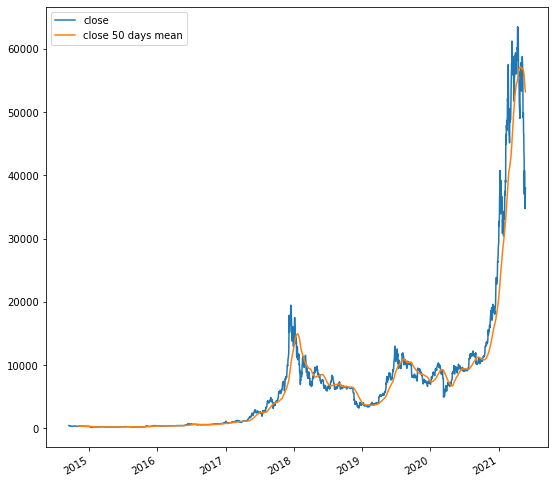

In [30]:
df[['close', 'close 50 days mean']].plot(figsize = (9, 9))

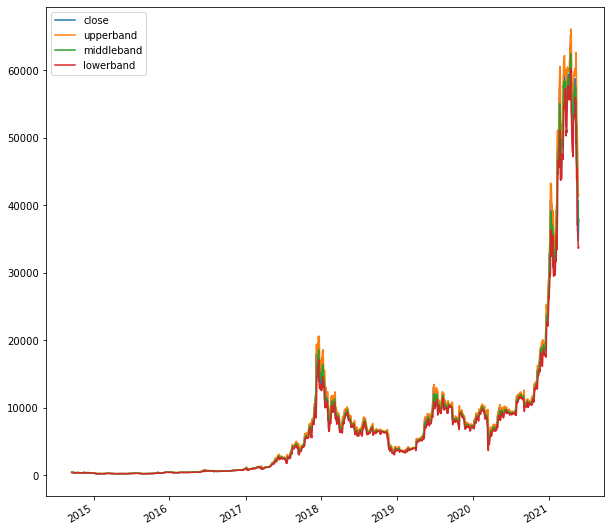

In [31]:
df[['close', 'upperband', 'middleband', 'lowerband']].plot(figsize = (10, 10))

In [ ]:
"""on va creer la dataset"""

In [32]:
scaler_dict = {}

In [33]:
"""Pre-processing de la data

/!\ il faut bien sauvegarder le scaler, car il dépend du min et du max de la colonne !, on ne poourra pas de-scale apres sinon

"""

# pas ca scale_training_set = sklearn.preprocessing.MinMaxScaler(df)




for column in features:
    scaler = pp.MinMaxScaler()
    df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
    #on conserve le scaler de chaque colonne car il dépend de la colonne
    scaler_dict[column] = scaler
    
    
    
    

In [34]:
scaler_dict

{'open': MinMaxScaler(),
 'high': MinMaxScaler(),
 'low': MinMaxScaler(),
 'close': MinMaxScaler(),
 'volume': MinMaxScaler(),
 'close 7 days mean': MinMaxScaler(),
 'close 14 days mean': MinMaxScaler(),
 'close 20 days mean': MinMaxScaler(),
 'close 50 days mean': MinMaxScaler(),
 'ema': MinMaxScaler(),
 'upperband': MinMaxScaler(),
 'middleband': MinMaxScaler(),
 'lowerband': MinMaxScaler(),
 'rsi': MinMaxScaler(),
 'macd': MinMaxScaler(),
 'bop': MinMaxScaler(),
 'obv': MinMaxScaler(),
 'natr': MinMaxScaler(),
 'sine': MinMaxScaler(),
 'leadsine': MinMaxScaler(),
 'CDLKICKINGBYLENGTH': MinMaxScaler(),
 'CDLTAKURI': MinMaxScaler(),
 'CDLHARAMI': MinMaxScaler(),
 'CDLDOJI': MinMaxScaler(),
 'CDLDRAGONFLYDOJI': MinMaxScaler(),
 'CDLLONGLEGGEDDOJI': MinMaxScaler()}

In [35]:
df.head()

,open,high,low,close,volume,close 7 days mean,close 14 days mean,close 20 days mean,close 50 days mean,ema,...,obv,natr,sine,leadsine,CDLKICKINGBYLENGTH,CDLTAKURI,CDLHARAMI,CDLDOJI,CDLDRAGONFLYDOJI,CDLLONGLEGGEDDOJI
2014-09-16,0.004562,0.003967,0.004528,0.004409,0.000043,NaN,NaN,NaN,NaN,NaN,...,0.000136,NaN,NaN,NaN,0.0,0.0,0.5,0.0,0.0,0.0
2014-09-17,0.004420,0.003792,0.003894,0.003890,0.000081,NaN,NaN,NaN,NaN,NaN,...,0.000123,NaN,NaN,NaN,0.0,0.0,0.5,0.0,0.0,0.0
2014-09-18,0.003902,0.003343,0.003434,0.003422,0.000091,NaN,NaN,NaN,NaN,NaN,...,0.000109,NaN,NaN,NaN,0.0,0.0,0.5,0.0,0.0,0.0
2014-09-19,0.003438,0.003272,0.003520,0.003645,0.000088,NaN,NaN,NaN,NaN,NaN,...,0.000123,NaN,NaN,NaN,0.0,0.0,0.5,0.0,0.0,0.0
2014-09-20,0.003650,0.003104,0.003573,0.003485,0.000059,NaN,NaN,NaN,NaN,NaN,...,0.000113,NaN,NaN,NaN,0.0,0.0,0.5,0.0,0.0,0.0


In [36]:
"""on scale la dataframe, ie on fait les deux opérations
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
"""




'on scale la dataframe, ie on fait les deux opérations\nX_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))\nX_scaled = X_std * (max - min) + min\n'

In [37]:
"""On crée futur"""
df['futur'] = df['close'].shift(-days_predicted)

In [38]:
df.shape

(2438, 29)

In [39]:
"""Ici, on supprime de nouveau les NaN créés lors du calcul des indicateurs, la moyenne mobile 50j n'est pas définie 
les 50 premiers jours"""

"Ici, on supprime de nouveau les NaN créés lors du calcul des indicateurs, la moyenne mobile 50j n'est pas définie \nles 50 premiers jours"

In [40]:
df.dropna(inplace = True)

In [41]:
df.shape

(2365, 29)

In [ ]:
"""on veut shuffle y et c de la meme maniere """

In [42]:
"""Préparation des séquences de prix des 50 derniers jours que l'on va considérer"""

sequence_tot = []
sequence = []
i = 0
for input, tgt, current in zip(df[features].values, df['futur'].values, df['close'].values):
    sequence.append(input)
    if len(sequence) == n: #dès que len(sequence) = n, on stock la sequence dans sequence_tot
                            #dès lors, on supprime le premier élément de sequence, et on ajoute l'entrée à la fin, 
                            #ça garde une séquence de 50
        sequence_tot.append([np.array(sequence), tgt, current])
        sequence.pop(0)


#tous les n, on ajoute tgt = target, avec df['futur'] qui est décalé de days_predicted 
#donc avec les n valeurs des n_features features, on va essayer de trouver la target 
#donc, si n=50 et days_predicted=10, last_sequence devrait être de longueur 60 (50+10)


    
x_data, y_data = [], [] #c correspond à current, c'est le prix à la date considérée, on en aura besoin pour déterminer le bénéfice
#y est la donnée à déterminer, à savoir le prix à t + 10
for s, tgt, current in sequence_tot:
    x_data.append(s)
    y_data.append((tgt, current))
x_data, y_data = np.array(x_data), np.array(y_data)


In [43]:
y_data.shape

(2306, 2)

In [ ]:
"""/!\ ne pas executer le bloc qui suit"""

In [ ]:
#Nous avons essayé de coder par nous-mêmes la séparation des données... ça n'a pas bien fonctionné

In [ ]:
"""/!\ Ne pas lancer cette cellule"""
"""Préparation des séquences de prix des 50 derniers jours que l'on va considérer"""

sequence_tot = []
sequence = []
i = 0
for input, tgt, current in zip(df[features].values, df['futur'].values, df['close'].values):
    sequence.append(input)
    if len(sequence) == n: #dès que len(sequence) = n, on stock la sequence dans sequence_tot
                            #dès lors, on supprime le premier élément de sequence, et on ajoute l'entrée à la fin, 
                            #ça garde une séquence de 50
        sequence_tot.append([np.array(sequence), tgt, current])
        sequence.pop(0)


#tous les n, on ajoute tgt = target, avec df['futur'] qui est décalé de days_predicted 
#donc avec les n valeurs des n_features features, on va essayer de trouver la target 
#donc, si n=50 et days_predicted=10, last_sequence devrait être de longueur 60 (50+10)


    
x_data, y_data, c_data = [], [], [] #c correspond à current, c'est le prix à la date considérée, on en aura besoin pour déterminer le bénéfice
#y est la donnée à déterminer, à savoir le prix à t + 10
for s, tgt, current in sequence_tot:
    x_data.append(s)
    y_data.append(tgt)
    c_data.append(current)
x_data, y_data, c_data = np.array(x_data), np.array(y_data), np.array(c_data)


In [ ]:
"""/!\ Ne pas lancer cette cellule"""
idx = int((1 - test_size) * len(x_data))
          
x_train = x_data[:idx] #"""on prend les premiers pour le train"""
y_train = y_data[:idx] #"""on prend les premiers pour le train"""
x_test  = x_data[idx:] #"""on prend les derniers pour le test"""
y_test = y_data[idx:] #"""on prend les derniers pour le test"""
c_test = c_data[idx:]

In [44]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x_data, y_data, test_size=test_size, shuffle=shuffle)

In [45]:
y_test

array([[1.64342722e-01, 1.63605196e-01],
       [9.05827424e-01, 7.53745948e-01],
       [3.71421548e-03, 3.84659524e-03],
       [1.81271741e-01, 1.27525342e-01],
       [1.67154682e-01, 1.76484152e-01],
       [6.31125881e-02, 6.13829486e-02],
       [3.88752688e-03, 3.84271051e-03],
       [1.04348679e-01, 1.15531402e-01],
       [1.73600252e-01, 1.78639301e-01],
       [6.58347187e-02, 9.76131493e-02],
       [1.76001603e-01, 1.45230687e-01],
       [7.62522426e-04, 7.22143546e-04],
       [6.46936799e-03, 7.52066846e-03],
       [9.27584051e-01, 9.18045267e-01],
       [4.45919347e-03, 4.37414038e-03],
       [4.15767136e-03, 3.84460541e-03],
       [1.93117421e-01, 1.40601815e-01],
       [6.01177502e-02, 6.11227982e-02],
       [3.97329031e-03, 3.88354721e-03],
       [7.84061956e-04, 8.81353090e-04],
       [1.53050731e-01, 1.46591452e-01],
       [6.59182561e-02, 6.63008830e-02],
       [1.08099151e-01, 1.10344384e-01],
       [4.52628344e-01, 3.67928333e-01],
       [4.156340

In [46]:
y_test, c_test = y_test[:,0], y_test[:,1]

In [47]:
y_test

array([1.64342722e-01, 9.05827424e-01, 3.71421548e-03, 1.81271741e-01,
       1.67154682e-01, 6.31125881e-02, 3.88752688e-03, 1.04348679e-01,
       1.73600252e-01, 6.58347187e-02, 1.76001603e-01, 7.62522426e-04,
       6.46936799e-03, 9.27584051e-01, 4.45919347e-03, 4.15767136e-03,
       1.93117421e-01, 6.01177502e-02, 3.97329031e-03, 7.84061956e-04,
       1.53050731e-01, 6.59182561e-02, 1.08099151e-01, 4.52628344e-01,
       4.15634016e-02, 1.19240549e-02, 2.73964469e-01, 5.91519110e-02,
       1.31209534e-01, 3.14594400e-03, 3.67928333e-01, 1.16123481e-01,
       6.14446495e-02, 7.58876144e-03, 2.94210271e-02, 6.48334311e-04,
       8.82979802e-04, 1.66379956e-02, 5.86467410e-01, 9.15415481e-04,
       4.00877340e-03, 5.80534443e-02, 1.11796644e-01, 4.54772021e-03,
       3.24552010e-02, 1.26099839e-01, 5.89555548e-02, 9.64305433e-01,
       3.29166757e-03, 1.59473107e-01, 8.08254441e-04, 4.36891350e-03,
       1.02623145e-01, 1.50827759e-01, 1.55181083e-01, 1.13395337e-02,
      

In [ ]:
"""On a pas besion de c_train, on a juste besoin de c_test pour calculer les benefices, on garde juste y_train"""

In [48]:
y_train

array([[0.00355804, 0.00163522],
       [0.21116955, 0.20139542],
       [0.07930888, 0.13544564],
       ...,
       [0.01173162, 0.01019941],
       [0.14216919, 0.14990262],
       [0.1223777 , 0.13242585]])

In [49]:
y_train = y_train[:,0]

In [50]:
x_train = np.asarray(x_train).astype('float64')
y_train = np.asarray(y_train).astype('float64')
x_test = np.asarray(x_test).astype('float64')
y_test = np.asarray(y_test).astype('float64')

In [51]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1844, 60, 26), (1844,), (462, 60, 26), (462,))

In [52]:
df.tail(days_predicted)

,open,high,low,close,volume,close 7 days mean,close 14 days mean,close 20 days mean,close 50 days mean,ema,...,natr,sine,leadsine,CDLKICKINGBYLENGTH,CDLTAKURI,CDLHARAMI,CDLDOJI,CDLDRAGONFLYDOJI,CDLLONGLEGGEDDOJI,futur
2021-05-04,0.837852,0.892474,0.851059,0.903997,0.197273,0.910503,0.903067,0.925677,0.996246,0.956918,...,0.274588,0.975302,0.726336,0.0,0.0,0.5,0.0,0.0,0.0,0.735599
2021-05-05,0.903982,0.899464,0.889962,0.887771,0.198077,0.917098,0.908600,0.921320,0.995376,0.957385,...,0.278715,0.879383,0.537969,0.0,0.0,0.5,0.0,0.0,0.0,0.730797
2021-05-06,0.887764,0.903228,0.888985,0.902929,0.194973,0.916184,0.916077,0.918518,0.995199,0.958885,...,0.273976,0.722219,0.340414,0.0,0.0,0.5,0.0,0.0,0.0,0.684709
2021-05-07,0.902584,0.916499,0.915636,0.925785,0.186280,0.918448,0.926527,0.920697,0.995360,0.961891,...,0.261279,0.568089,0.197885,0.0,0.0,0.5,0.0,0.0,0.0,0.674790
2021-05-08,0.926652,0.912574,0.907685,0.916761,0.187772,0.922165,0.937545,0.922808,0.995331,0.964071,...,0.261331,0.428325,0.099416,0.0,0.0,0.5,0.0,0.0,0.0,0.581510
2021-05-09,0.916762,0.917345,0.868829,0.879295,0.204497,0.919053,0.939739,0.922292,0.994747,0.963482,...,0.291133,0.235358,0.012899,0.0,0.0,0.5,0.0,0.0,0.0,0.641207
2021-05-10,0.878818,0.876405,0.877488,0.892636,0.174670,0.926878,0.941735,0.924648,0.995511,0.963867,...,0.278853,0.214666,0.007907,0.0,0.0,0.5,0.0,0.0,0.0,0.586283
2021-05-11,0.892509,0.892907,0.789507,0.773346,0.214295,0.907675,0.934960,0.922449,0.993547,0.955860,...,0.374243,0.110455,0.002903,0.0,0.0,0.5,0.0,0.0,0.0,0.589946
2021-05-12,0.782336,0.790689,0.754520,0.782279,0.275572,0.892170,0.930377,0.921290,0.992472,0.948997,...,0.375527,0.031982,0.044644,0.0,0.0,1.0,1.0,0.0,1.0,0.546266
2021-05-13,0.781508,0.792348,0.784962,0.784874,0.158797,0.874819,0.920981,0.921146,0.991831,0.942759,...,0.365255,0.000299,0.134440,0.0,0.0,0.5,1.0,0.0,1.0,0.597039


In [55]:
l1_reg = tf.keras.regularizers.l1(0.01)

In [73]:
"""Paramètres"""
#paramètres sur les données
n = 60
days_predicted = 10
test_size = 0.2
features = possible_features

#paramètres uniquement du modèle
nb_neurons = 256
dropout = 0.4 #"désactive" certains neurones pour réduire l'overfitting
n_features = len(features) #len de la dataframe
e = 400 #nombre d'epoch
b_s = 32 #c'est la taille du batch
BiDi = False
k_reg = l1_reg
b_reg = l1_reg
str_k_reg = 'l1_reg'
str_b_reg = 'l1_reg'

In [74]:
def mod_name(ticker, BiDi, n, days_predicted, test_size, nb_neurons, dropout, n_features, e, b_s, str_k_reg, str_b_reg):
    return ticker + '__' + 'BiDi' + str(BiDi) + '__' + 'n' + str(n) + '__' + 'days_predicted' + str(days_predicted) + '__' + 'test_size' + str(test_size) + '__' + 'nb_neurons' + str(nb_neurons) + '__' + 'dropout' + str(dropout) + '__' + 'n_features' + str(n_features) + '__' + 'e' + str(e) + '__' + 'b_s' + str(b_s) + '__' + 'k_reg' + str_k_reg + '__' + 'bias_reg' + str_b_reg

In [76]:
name = mod_name(ticker, BiDi, n, days_predicted, test_size, nb_neurons, dropout, n_features, e, b_s, str_k_reg, str_b_reg)

In [77]:
name

'BTC-USD__BiDiFalse__n60__days_predicted10__test_size0.2__nb_neurons256__dropout0.4__n_features26__e400__b_s32__k_regl1_reg__bias_regl1_reg'

In [78]:
def modele(nb_neurons, dropout, n, n_features, BiDi, k_reg, b_reg):

    if BiDi :
        """Bidirectionnel, n_layers = 2"""

        mod = tf.keras.Sequential()

        mod.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(nb_neurons, 
                                                                   return_sequences=True, 
                                                                   batch_input_shape=(None, n, n_features),
                                                                   kernel_regularizer = k_reg,
                                                                   bias_regularizer = b_reg)))
        mod.add(tf.keras.layers.Dropout(dropout))
        mod.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(nb_neurons, 
                                                                   return_sequences=False, 
                                                                   kernel_regularizer = k_reg,
                                                                   bias_regularizer = b_reg)))
        mod.add(tf.keras.layers.Dropout(dropout))

        mod.add(tf.keras.layers.Dense(1, 
                                      activation='tanh',
                                      kernel_regularizer = k_reg,
                                      bias_regularizer = b_reg)) 
        mod.compile(loss='mean_absolute_error', metrics=['mean_absolute_error'], optimizer='adam')
        
        
    else :
        mod = tf.keras.Sequential()
        
        mod.add(tf.keras.layers.LSTM(nb_neurons, 
                                     return_sequences=True, 
                                     batch_input_shape=(None, n, n_features), 
                                     kernel_regularizer = k_reg,
                                     bias_regularizer = b_reg))
        mod.add(tf.keras.layers.Dropout(dropout))
        mod.add(tf.keras.layers.LSTM(nb_neurons, 
                                     return_sequences=False,
                                     kernel_regularizer = k_reg,
                                     bias_regularizer = b_reg))
        mod.add(tf.keras.layers.Dropout(dropout))

        mod.add(tf.keras.layers.Dense(1, 
                                      activation='tanh',
                                      kernel_regularizer = k_reg,
                                      bias_regularizer = b_reg)) 
        mod.compile(loss='huber_loss', metrics=['mean_absolute_error'], optimizer='adam') #adam est un algorithme d'optimisation (ADAptative Moment)

    return mod
        






In [80]:
mod = modele(nb_neurons, dropout, n, n_features, BiDi, k_reg, b_reg)

In [81]:
mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 256)           289792    
_________________________________________________________________
dropout (Dropout)            (None, 60, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 815,361
Trainable params: 815,361
Non-trainable params: 0
_________________________________________________________________


In [82]:
"""création des dossiers pour les logs"""

if not os.path.isdir("logs"):
    os.mkdir("logs")


In [83]:
#on utilise tensorboard pour visualiser la loss etc au fil des epochs

tensorboard = tf.keras.callbacks.TensorBoard(log_dir=os.path.join("logs", name))

In [84]:
mod.fit(x_train, y_train,
                    batch_size=b_s,
                    epochs=e,
                    validation_data=(x_test, y_test),
                    callbacks=[tensorboard],
                    verbose=1)

Train on 1844 samples, validate on 462 samples
Epoch 1/400
1844/1844 [==============================] - 10s 6ms/sample - loss: 46.8924 - mean_absolute_error: 0.0447 - val_loss: 9.4673 - val_mean_absolute_error: 0.0363
Epoch 2/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 6.0259 - mean_absolute_error: 0.1100 - val_loss: 4.9631 - val_mean_absolute_error: 0.1087
Epoch 3/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 4.7708 - mean_absolute_error: 0.1017 - val_loss: 4.6098 - val_mean_absolute_error: 0.1085
Epoch 4/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 4.4614 - mean_absolute_error: 0.1022 - val_loss: 4.3098 - val_mean_absolute_error: 0.1096
Epoch 5/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 4.1646 - mean_absolute_error: 0.1037 - val_loss: 4.0136 - val_mean_absolute_error: 0.1102
Epoch 6/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 3.8676 - mean_absolute_erro

Epoch 49/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3778 - mean_absolute_error: 0.1043 - val_loss: 0.3781 - val_mean_absolute_error: 0.1106
Epoch 50/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3777 - mean_absolute_error: 0.1044 - val_loss: 0.3801 - val_mean_absolute_error: 0.1105
Epoch 51/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3776 - mean_absolute_error: 0.1037 - val_loss: 0.3820 - val_mean_absolute_error: 0.1106
Epoch 52/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3778 - mean_absolute_error: 0.1042 - val_loss: 0.3798 - val_mean_absolute_error: 0.1107
Epoch 53/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3777 - mean_absolute_error: 0.1041 - val_loss: 0.3825 - val_mean_absolute_error: 0.1106
Epoch 54/400
1844/1844 [==============================] - 5s 2ms/sample - loss: 0.3777 - mean_absolute_error: 0.1045 - val_loss: 0.3788 - val_mean_abs

1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3778 - mean_absolute_error: 0.1041 - val_loss: 0.3791 - val_mean_absolute_error: 0.1108
Epoch 98/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3777 - mean_absolute_error: 0.1035 - val_loss: 0.3819 - val_mean_absolute_error: 0.1107
Epoch 99/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3776 - mean_absolute_error: 0.1050 - val_loss: 0.3826 - val_mean_absolute_error: 0.1107
Epoch 100/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3778 - mean_absolute_error: 0.1038 - val_loss: 0.3805 - val_mean_absolute_error: 0.1104
Epoch 101/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3777 - mean_absolute_error: 0.1037 - val_loss: 0.3780 - val_mean_absolute_error: 0.1110
Epoch 102/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3777 - mean_absolute_error: 0.1041 - val_loss: 0.3784 - val_mean_absolute_erro

1844/1844 [==============================] - 5s 3ms/sample - loss: 0.3777 - mean_absolute_error: 0.1041 - val_loss: 0.3770 - val_mean_absolute_error: 0.1103
Epoch 146/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3777 - mean_absolute_error: 0.1046 - val_loss: 0.3795 - val_mean_absolute_error: 0.1101
Epoch 147/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3777 - mean_absolute_error: 0.1041 - val_loss: 0.3821 - val_mean_absolute_error: 0.1098
Epoch 148/400
1844/1844 [==============================] - 5s 2ms/sample - loss: 0.3777 - mean_absolute_error: 0.1035 - val_loss: 0.3801 - val_mean_absolute_error: 0.1108
Epoch 149/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3778 - mean_absolute_error: 0.1044 - val_loss: 0.3790 - val_mean_absolute_error: 0.1105
Epoch 150/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3777 - mean_absolute_error: 0.1041 - val_loss: 0.3786 - val_mean_absolute_er

Epoch 193/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3776 - mean_absolute_error: 0.1038 - val_loss: 0.3802 - val_mean_absolute_error: 0.1105
Epoch 194/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3778 - mean_absolute_error: 0.1039 - val_loss: 0.3781 - val_mean_absolute_error: 0.1113
Epoch 195/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3777 - mean_absolute_error: 0.1045 - val_loss: 0.3809 - val_mean_absolute_error: 0.1107
Epoch 196/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3777 - mean_absolute_error: 0.1040 - val_loss: 0.3790 - val_mean_absolute_error: 0.1104
Epoch 197/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3778 - mean_absolute_error: 0.1038 - val_loss: 0.3780 - val_mean_absolute_error: 0.1106
Epoch 198/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3777 - mean_absolute_error: 0.1041 - val_loss: 0.3801 - val_me

Epoch 241/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3777 - mean_absolute_error: 0.1043 - val_loss: 0.3759 - val_mean_absolute_error: 0.1105
Epoch 242/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3778 - mean_absolute_error: 0.1032 - val_loss: 0.3787 - val_mean_absolute_error: 0.1104
Epoch 243/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3775 - mean_absolute_error: 0.1051 - val_loss: 0.3812 - val_mean_absolute_error: 0.1105
Epoch 244/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3778 - mean_absolute_error: 0.1035 - val_loss: 0.3774 - val_mean_absolute_error: 0.1103
Epoch 245/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3777 - mean_absolute_error: 0.1043 - val_loss: 0.3800 - val_mean_absolute_error: 0.1105
Epoch 246/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3776 - mean_absolute_error: 0.1040 - val_loss: 0.3804 - val_me

Epoch 289/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3776 - mean_absolute_error: 0.1041 - val_loss: 0.3785 - val_mean_absolute_error: 0.1106
Epoch 290/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3776 - mean_absolute_error: 0.1039 - val_loss: 0.3797 - val_mean_absolute_error: 0.1105
Epoch 291/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3777 - mean_absolute_error: 0.1036 - val_loss: 0.3834 - val_mean_absolute_error: 0.1113
Epoch 292/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3777 - mean_absolute_error: 0.1050 - val_loss: 0.3789 - val_mean_absolute_error: 0.1111
Epoch 293/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3776 - mean_absolute_error: 0.1039 - val_loss: 0.3804 - val_mean_absolute_error: 0.1103
Epoch 294/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3776 - mean_absolute_error: 0.1035 - val_loss: 0.3806 - val_me

Epoch 337/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3776 - mean_absolute_error: 0.1043 - val_loss: 0.3780 - val_mean_absolute_error: 0.1104
Epoch 338/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3775 - mean_absolute_error: 0.1040 - val_loss: 0.3824 - val_mean_absolute_error: 0.1102
Epoch 339/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3777 - mean_absolute_error: 0.1045 - val_loss: 0.3807 - val_mean_absolute_error: 0.1105
Epoch 340/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3776 - mean_absolute_error: 0.1036 - val_loss: 0.3804 - val_mean_absolute_error: 0.1097
Epoch 341/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3777 - mean_absolute_error: 0.1037 - val_loss: 0.3792 - val_mean_absolute_error: 0.1104
Epoch 342/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3777 - mean_absolute_error: 0.1042 - val_loss: 0.3784 - val_me

Epoch 385/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3776 - mean_absolute_error: 0.1038 - val_loss: 0.3802 - val_mean_absolute_error: 0.1104
Epoch 386/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3777 - mean_absolute_error: 0.1044 - val_loss: 0.3806 - val_mean_absolute_error: 0.1104
Epoch 387/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3776 - mean_absolute_error: 0.1037 - val_loss: 0.3806 - val_mean_absolute_error: 0.1104
Epoch 388/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3777 - mean_absolute_error: 0.1037 - val_loss: 0.3801 - val_mean_absolute_error: 0.1104
Epoch 389/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3776 - mean_absolute_error: 0.1045 - val_loss: 0.3792 - val_mean_absolute_error: 0.1101
Epoch 390/400
1844/1844 [==============================] - 4s 2ms/sample - loss: 0.3777 - mean_absolute_error: 0.1042 - val_loss: 0.3788 - val_me

In [85]:
mod.save(name + '.h5')

In [ ]:
"""avec 256 on etait a 30s / epoch la on est a 120"""

In [ ]:
"""1843/1843 [==============================] - 135s 73ms/sample - loss: 1.3219e-04 - mean_absolute_error: 0.0097 - val_loss: 8.2145e-05 - val_mean_absolute_error: 0.0076"""

In [ ]:
loaded_nflx = tf.keras.models.load_model('NFLX__BiDiFalse__n60__days_predicted10__test_size0.2__nb_neurons256__dropout0.4__n_features26__e600__b_s32__LSTMlayers5.h5')

In [ ]:
y_pred = loaded_nflx.predict(x_test)

In [ ]:
y_pred.shape

In [86]:
y_pred = mod.predict(x_test)

In [87]:
y_pred.shape

(462, 1)

In [88]:
y_test.shape

(462,)

In [89]:
"""on met y_test sous la meme shape que y_pred pour la suite"""

'on met y_test sous la meme shape que y_pred pour la suite'

In [ ]:
y_test

In [90]:
y_test = np.reshape(y_test, (y_pred.shape))

In [91]:
y_test.shape

(462, 1)

In [92]:
c_test = np.reshape(c_test, (y_pred.shape))

In [93]:
c_test.shape

(462, 1)

In [94]:
"""On descale les sortie pour comparer les prix en USD"""

'On descale les sortie pour comparer les prix en USD'

In [95]:
#Une fois les données obtenues, on "descale" les prix pour trouver les vraies valeurs
y_test_descaled = np.squeeze(scaler_dict['close'].inverse_transform(y_test))
y_pred_descaled = np.squeeze(scaler_dict['close'].inverse_transform(y_pred))
c_test_descaled = np.squeeze(scaler_dict['close'].inverse_transform(c_test))

In [96]:
buy_profit  = lambda current, true_futur, pred_futur: true_futur - current if pred_futur > current else 0
sell_profit = lambda current, true_futur, pred_futur: current - true_futur if pred_futur < current else 0
#la gestion de portefeuille n'est pas l'objet de ce projet : on achete une unité d'action (ou de bitcoin ici), et on revend également une unité, independament de ce que cela représente comme part de notre capital.
#la stratégie d'investissement est basique : si on s'attend à ce que les prix augmentent, on achète (dans l'optique de revendre après)
#si on s'attend à ce que les prix diminuent, on vend (et on achète après)

In [97]:
buy_prft = list(map(buy_profit, 
                                c_test_descaled, 
                                y_test_descaled, 
                                y_pred_descaled)
                                
                                )

sell_prft = list(map(sell_profit, 
                                c_test_descaled, 
                                y_test_descaled, 
                                y_pred_descaled)
                                # since we don't have profit for last sequence, add 0's
                                )

In [98]:
buy_prft

[0,
 0,
 -8.38299560546875,
 0,
 0,
 109.53002929687455,
 2.8380126953125,
 0,
 0,
 -2012.38037109375,
 0,
 2.5570068359375,
 -66.573974609375,
 0,
 5.386016845703125,
 19.82501220703125,
 0,
 -63.64501953124909,
 5.683013916015625,
 -6.1609954833984375,
 0,
 -24.22998046875,
 -142.18017578125,
 0,
 411.280029296875,
 142.3690185546875,
 0,
 227.859619140625,
 0,
 55.29901123046875,
 0,
 0,
 36.59985351562409,
 34.68701171875,
 192.6300048828125,
 -34.53800964355469,
 -6.2779998779296875,
 31.3399658203125,
 0,
 -8.151992797851562,
 14.686004638671875,
 224.5703125,
 81.25048828125,
 35.516998291015625,
 -368.2998046875,
 1139.89990234375,
 28.7880859375,
 0,
 -5.60400390625,
 0,
 6.40399169921875,
 10.09698486328125,
 395.5498046875,
 0,
 0,
 118.09497070312511,
 -11.5150146484375,
 1219.1474609375,
 0,
 0,
 25.3489990234375,
 23.94000244140625,
 0,
 226.10986328125,
 449.159912109375,
 193.546630859375,
 0,
 525.080078125,
 40.7659912109375,
 0,
 195.92724609375,
 454.669921875,
 0,


In [99]:
sell_prft

[-46.7041015625,
 -9630.61328125,
 0,
 -3403.509765625,
 590.7919921875,
 0,
 0,
 708.14990234375,
 319.099609375,
 0,
 -1948.5791015625,
 0,
 0,
 -604.046875,
 0,
 0,
 -3325.5693359375,
 0,
 0,
 0,
 -409.0361328125,
 0,
 0,
 -5363.658203125,
 0,
 0,
 -1688.5000000000018,
 0,
 1860.7197265625,
 0,
 -5212.302734375,
 1046.31201171875,
 0,
 0,
 0,
 0,
 0,
 0,
 -4534.3359375,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -10704.84375,
 0,
 76.5087890625,
 0,
 0,
 0,
 631.22265625,
 -1078.4296875,
 0,
 0,
 0,
 -152.330078125,
 -7307.123046874996,
 0,
 0,
 -177.4326171875,
 0,
 0,
 0,
 -206.419921875,
 0,
 0,
 851.20703125,
 0,
 0,
 -1275.2001953125,
 0,
 0,
 1667.58984375,
 119.2900390625,
 448.7333984375,
 0,
 0,
 0,
 -361.14990234375,
 0,
 0,
 4165.0,
 0,
 1033.8779296875,
 291.51025390625,
 -2447.26171875,
 -2488.3193359375,
 0,
 525.3076171875,
 0,
 0,
 -1507.599609375,
 -821.0673828125,
 0,
 0,
 1641.9404296875,
 0,
 -813.115234375,
 0,
 -3.259765625,
 0,
 -8833.46484375,
 0,
 -11803.82421875,
 0,

In [100]:
# on calcule l'accuracy en regardant la proportion de profit positif
accuracy = (len([e for e in sell_prft if e > 0]) + len([e for e in buy_prft if e > 0])) / len(y_pred)

In [101]:
tot_buy_profit  = sum(buy_prft)
tot_sell_profit = sum(sell_prft)
tot_profit = tot_buy_profit + tot_sell_profit
profit_per_trade = tot_profit / len(y_pred)

In [102]:
tot_buy_profit, tot_sell_profit

(20985.28172302246, -144288.30078125)

In [103]:
tot_profit, profit_per_trade

(-123303.01905822754, -266.88965164118514)

In [104]:
accuracy

0.5670995670995671

In [ ]:
50000/240

In [ ]:
tot_profit * 208